# Import dependencies

In [1]:
# Reload modules whenever underlying code changes
%load_ext autoreload
%autoreload 2

In [2]:
# pdb will automatically run on exceptions
#%pdb on # currently not working due to https://github.com/ipython/ipykernel/issues/422

In [3]:
# import os

# # Only occupy one GPU, as in https://stackoverflow.com/questions/37893755/tensorflow-set-cuda-visible-devices-within-jupyter
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# # Only allocate GPU memory as needed
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

# # Suppress tf warning messages
# os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

In [4]:
%matplotlib inline
from sgm.dependencies import *

# Initialize untrained agent

In [5]:
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.enable_eager_execution(config=config)

In [6]:
#tf.debugging.set_log_device_placement(True)
#tf.test.is_gpu_available()

In [7]:
tf.compat.v1.reset_default_graph()

In [8]:
from sgm.envs import env_load_fn
from sgm.agent import UvfAgent

# If you change the environment parameters below, make sure to run
# tf.reset_default_graph() in the cell above before training.
max_episode_steps = 20
env_name = 'FourRooms'  # Choose one of the environments shown above. 
resize_factor = 5  # Inflate the environment to increase the difficulty.
thin = True # If True, resize by expanding open space, not walls, to make walls thin
desc_name = "thinned_" + env_name.lower() if thin else env_name.lower()

base_dir = os.path.join(os.getcwd(), os.pardir, "agents")
model_dir = os.path.join(base_dir, desc_name)

tf_env = env_load_fn(env_name, max_episode_steps,
                     resize_factor=resize_factor,
                     terminate_on_timeout=False,
                     thin=thin)
eval_tf_env = env_load_fn(env_name, max_episode_steps,
                          resize_factor=resize_factor,
                          terminate_on_timeout=True,
                          thin=thin)

agent = UvfAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    max_episode_steps=max_episode_steps,
    use_distributional_rl=True,
    ensemble_size=3)

/Users/josephdoan/opt/anaconda3/envs/sgm/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Train the agent

In [9]:
# from sgm.trainer import train_eval

# train_eval(agent,
#           tf_env,
#           eval_tf_env,
#           initial_collect_steps=1000,
#           eval_interval=1000,
#           num_eval_episodes=10,
#           num_iterations=30000,
#           save_model_dir=model_dir,
#           experiment_name=f"{env_name}_coordinate_{max_episode_steps}steps")

# Load trained model into agent

In [10]:
filename = "FourRooms_coordinate_20steps-Dec-05-2019-12-58-28-PM/ckpt/"
checkpoint_file = os.path.join(model_dir, filename)

ckpt = tf.train.Checkpoint(step=tf.Variable(1), net=agent)
manager = tf.train.CheckpointManager(ckpt, checkpoint_file, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

# Fill replay buffer with random prefectly explored data

In [11]:
from sgm.envs import *

#@title Fill the replay buffer with random data  {vertical-output: true, run: "auto" }
replay_buffer_size = 2000 #@param {min:100, max: 1000, step: 100, type:"slider"}

eval_tf_env.pyenv.envs[0].gym.set_sample_goal_args(
    prob_constraint=0.0,
    min_dist=0,
    max_dist=np.inf)
rb_vec = []
for it in range(replay_buffer_size):
    ts = eval_tf_env.reset()
    rb_vec.append(ts.observation['observation'].numpy()[0])
rb_vec = np.array(rb_vec)

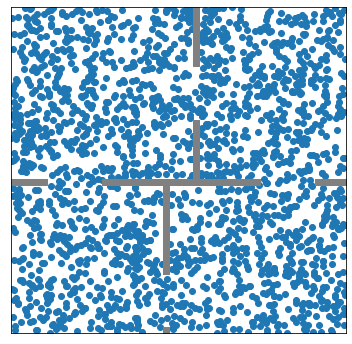

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(*rb_vec.T)
plot_walls(eval_tf_env.pyenv.envs[0].env.walls)
plt.show()

# Calculate qvalue distances

In [ ]:
pdist = agent._get_pairwise_dist(rb_vec, aggregate=None).numpy()

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(pdist.flatten(), bins=range(20))
plt.xlabel('predicted distance')
plt.ylabel('number of (s, g) pairs')
plt.show()

# Tune edge cutoff

In [ ]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=10) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=10)

from sgm.utils.visualization import *
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

In [ ]:
search_policy.keep_k_nearest(5)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

In [ ]:
search_policy.keep_k_nearest(4)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

In [ ]:
search_policy.keep_k_nearest(3)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

In [ ]:
search_policy.keep_k_nearest(2)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

In [ ]:
search_policy.keep_k_nearest(1)
plot_graph(search_policy._g.copy(), search_policy.rb_vec, eval_tf_env)

# Calculate Euclidean distances

In [ ]:
from scipy.spatial import distance
euclidean_dists = distance.pdist(rb_vec)

plt.figure(figsize=(6, 3))
plt.hist(euclidean_dists.flatten())
plt.xlabel('Euclidean distance')
plt.ylabel('number of pairwise distances')
plt.show()

# Initialize SGM search policy

In [ ]:
from sgm.planner import SGMSearchPolicy
search_policy_type = "SGM"
agent.initialize_search(rb_vec, max_search_steps=10) # needed to set agent attributes that SGMSearchPolicy constructor queries
search_policy = SGMSearchPolicy(agent, pdist, rb_vec, rb_vec, cache_pdist = True)
agent.initialize_search(search_policy.rb_vec, max_search_steps=10)

# Cleanup and evaluate SGM

In [ ]:
from sgm.evaluation import cleanup_and_eval

logdir = os.path.join(os.getcwd(), os.pardir, "logs")
eval_difficulty = 0.95
k_nearest = 5
eval_trials = 20
total_cleanup_steps = 100000
eval_period = 5000

logfolder = cleanup_and_eval(search_policy,
                             search_policy_type,
                             desc_name,
                             eval_tf_env,
                             logdir,
                             eval_difficulty=eval_difficulty,
                             k_nearest=k_nearest,
                             eval_trials=eval_trials,
                             total_cleanup_steps=total_cleanup_steps,
                             eval_period=eval_period)

# Load cleanup graphs

In [ ]:
from sgm.utils.visualization import *

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_initial"))
initial_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_0_cleanup_steps/"))
filtered_graph = search_policy._g.copy()

search_policy.load(os.path.join(logfolder, search_policy_type.lower().replace(" ", "_") + "_filtered_{}_cleanup_steps/".format(total_cleanup_steps)))
cleaned_graph = search_policy._g.copy()

pruned_graph = nx.difference(filtered_graph, cleaned_graph)

# Visualize cleanup graphs

In [ ]:
plot_points(search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(initial_graph, search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(filtered_graph, search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(cleaned_graph, search_policy.rb_vec, eval_tf_env)

In [ ]:
plot_graph(pruned_graph, search_policy.rb_vec, eval_tf_env)